# AfSIS Soil Chemistry Dataset - Modelling¶



## 1. Load libraries and data

In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
from sys import stdout
#from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor


import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.ridge import Ridge
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import xgboost 
from xgboost import XGBRegressor

from sklearn.datasets import make_regression
from sklearn import svm
import numpy as np
import time
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from IPython.display import Image

from sklearn.decomposition import PCA
from scipy.signal import savgol_filter

from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSCanonical
from sklearn.cross_decomposition import PLSSVD


from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.ridge module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
df_composition = pd.read_csv('elemental_analysis_dataset.csv')
#df_composition = df_composition.rename(columns={"P": "%P", "K": "%K","Ca": "%Ca", "Cu": "%Cu", "Fe": "%Fe", "Mo": "%Mo","Mg": "%Mg","S": "%S","Mn": "%Mn","Zn": "%Zn" , "Cl": "%Cl",})
df_composition.head()

,SSN,M3 Ca,M3 K,M3 Al,M3 P,M3 S,PH,Psa asand,Psa asilt,Psa aclay,...,Zn,Fe,Mn,Mo,Latitude,Longitude,Cluster,Depth,Country,Cultivated
0,icr006475,207.1,306.30,1095.000,4.495,18.960,4.682,97.848667,1.845333,0.306000,...,22.0,12501.3,81.9,184.5,-6.088750,36.435982,2,sub,Tanzania,False
1,icr006586,1665.0,1186.00,1165.000,12.510,13.600,7.062,89.520000,9.553667,0.926333,...,38.5,24094.6,422.4,184.5,-6.055750,36.457722,8,top,Tanzania,False
2,icr021104,258.7,35.25,441.400,4.424,3.608,5.522,89.950000,5.205000,4.845000,...,2.3,2213.4,13.2,184.5,-8.049305,37.333698,14,sub,Tanzania,False
3,icr033622,11858.3,1156.00,108.286,31.233,25.460,8.583,91.445000,6.310000,2.245000,...,29.8,24135.0,460.4,184.5,4.178087,38.261890,2,sub,Ethiopia,unknown
4,icr006570,896.2,607.30,1151.000,5.986,20.080,6.661,97.789667,1.885000,0.325667,...,13.4,9135.1,132.6,184.5,-6.069970,36.464588,7,top,Tanzania,False


In [4]:
print(df_composition.columns)

Index(['SSN', 'M3 Ca', 'M3 K', 'M3 Al', 'M3 P', 'M3 S', 'PH', 'Psa asand',
       'Psa asilt', 'Psa aclay', 'Volfr', 'Awc1', 'Lshrinkpct',
       'Flash2000_N_ppm', 'Acidified carbon', 'pH', 'Leco_N_ppm', 'C % Org',
       'ICP OES K mg/kg ', 'ICP OES P mg/kg ', 'P', 'K', 'S', 'Ca', 'Mg', 'Cu',
       'Cl', 'Zn', 'Fe', 'Mn', 'Mo', 'Latitude', 'Longitude', 'Cluster',
       'Depth', 'Country', 'Cultivated'],
      dtype='object')


## 2. Elemental analysis and soil fertility

### 2.1 Soil chemistry variables correlation

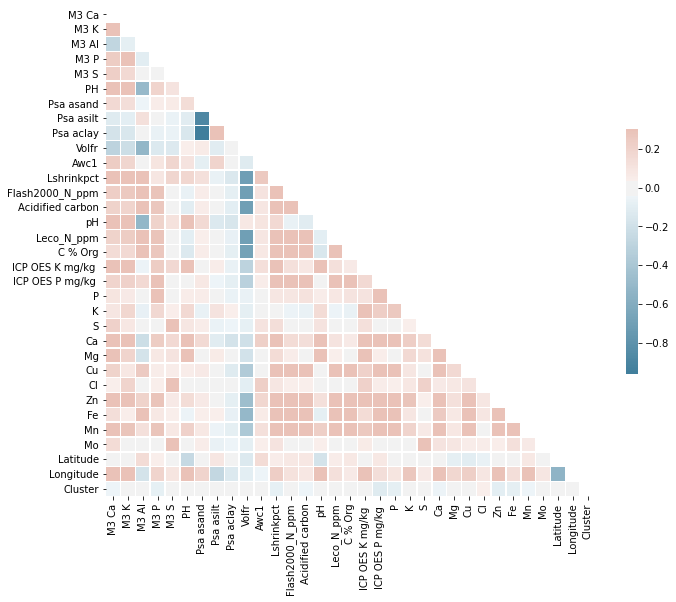

In [5]:
# Compute the correlation matrix
corr = df_composition.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The figures show poor correlation. Surprising that this is true comparing the same element concentration estimated using ICP Optical Emission Spectrometry (ICP-OES-K) and X-rays fluorescence (K)

### 2.2 Composition - fertility correlation

#### 2.2.1 Features selection

In [6]:
elemental_variables = ['pH','Acidified carbon', 'Flash2000_N_ppm','Awc1','P', 'K', 'S', 'Ca', 'Mg', 'Cu',
       'Cl', 'Zn', 'Fe', 'Mn', 'Mo', 'Depth', 'Cultivated']
# major and oligoelements are taken into account for the soil composition

df_composition_reduced = df_composition[elemental_variables]
print("AWC1 is a meaurement of water content")
print("Flash2000_N_ppm is a measurement of nitrogen concentration expressed in ppm")
print("acidified carbon is a measurement of % organic matter into the soil")
print('')
df_composition_reduced.head()

AWC1 is a meaurement of water content
Flash2000_N_ppm is a measurement of nitrogen concentration expressed in ppm
acidified carbon is a measurement of % organic matter into the soil



,pH,Acidified carbon,Flash2000_N_ppm,Awc1,P,K,S,Ca,Mg,Cu,Cl,Zn,Fe,Mn,Mo,Depth,Cultivated
0,4.57,0.429813,392.82719,0.034962,50.6,12991.3,45.7,944.1,5575.0,13.0,210.2,22.0,12501.3,81.9,184.5,sub,False
1,7.06,0.912364,859.46908,0.042649,50.6,15173.5,45.7,9301.0,5519.1,18.4,152.6,38.5,24094.6,422.4,184.5,top,False
2,5.27,0.219614,186.29957,0.091913,50.6,6838.9,45.7,884.3,5575.0,2.8,229.5,2.3,2213.4,13.2,184.5,sub,False
3,8.50,1.083015,1026.56581,0.159708,431.6,15845.8,45.7,46529.1,33771.2,13.0,58.2,29.8,24135.0,460.4,184.5,sub,unknown
4,6.50,0.527140,377.73812,0.033089,50.6,12201.6,45.7,1790.1,5575.0,7.7,122.5,13.4,9135.1,132.6,184.5,top,False


#### 2.2.2 Categorical features encoding

In [7]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(sparse=False)# label encoded values of depth
enc_df = pd.DataFrame(enc.fit_transform(df_composition_reduced[['Depth']]), columns = ['depth_sub','depth_top'])

df_composition_reduced = pd.merge(df_composition_reduced, enc_df, left_index=True, right_index=True)
df_composition_reduced = df_composition_reduced.reset_index(drop = True)


In [8]:
df_composition_cultivated  = df_composition_reduced[df_composition_reduced['Cultivated'] != "unknown"]  # eliminate unknown values
print(df_composition_cultivated['Cultivated'].unique())

['False' 'True']


In [9]:
# creating instance of labelencoder for the column "Cultivated"
labelencoder = LabelEncoder()# Assigning numerical values and storing in another column
df_composition_cultivated['Cultivated_n'] = labelencoder.fit_transform(df_composition_cultivated['Cultivated'])

print(df_composition_cultivated.shape)
df_composition_cultivated = df_composition_cultivated.drop(['Depth', 'Cultivated'], axis = 1)

(148, 20)


<ipython-input-9-d4eb68b28776>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_composition_cultivated['Cultivated_n'] = labelencoder.fit_transform(df_composition_cultivated['Cultivated'])


In [10]:
df_composition_cultivated.head()

,pH,Acidified carbon,Flash2000_N_ppm,Awc1,P,K,S,Ca,Mg,Cu,Cl,Zn,Fe,Mn,Mo,depth_sub,depth_top,Cultivated_n
0,4.57,0.429813,392.82719,0.034962,50.6,12991.3,45.7,944.1,5575.0,13.0,210.2,22.0,12501.3,81.9,184.5,1.0,0.0,0
1,7.06,0.912364,859.46908,0.042649,50.6,15173.5,45.7,9301.0,5519.1,18.4,152.6,38.5,24094.6,422.4,184.5,0.0,1.0,0
2,5.27,0.219614,186.29957,0.091913,50.6,6838.9,45.7,884.3,5575.0,2.8,229.5,2.3,2213.4,13.2,184.5,1.0,0.0,0
4,6.50,0.527140,377.73812,0.033089,50.6,12201.6,45.7,1790.1,5575.0,7.7,122.5,13.4,9135.1,132.6,184.5,0.0,1.0,0
5,5.41,4.359586,2520.21961,0.112162,50.6,4731.1,45.7,4924.8,5575.0,56.1,145.1,40.6,67075.9,586.1,184.5,0.0,1.0,0


#### 2.2.3 Data modeling - logistic regression

In [11]:

X_cultivated = df_composition_cultivated.drop(['Cultivated_n'], axis = 1).values[:, 1:]

X_cult_scaled = StandardScaler().fit_transform(X_cultivated) # scale those features
y_cultivated = df_composition_cultivated['Cultivated_n'].values

X1_train, X1_test, y1_train, y1_test = train_test_split(X_cult_scaled, y_cultivated, test_size = 0.2, random_state = 42)

In [12]:
lr_cultivated = LogisticRegression(solver='liblinear',dual=True, random_state=42)

lr_cultivated.fit(X1_train, y1_train)
y1_pred = lr_cultivated.predict(X1_test) # estimation of cultivated value based on fit
accuracy_lr = lr_cultivated.score(X1_test, y1_test)
print('Score of the logistic regression model for soil composition and fertility = ',np.round(accuracy_lr,2))

Score of the logistic regression model for soil composition and fertility =  0.9


/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [13]:
cm1 = confusion_matrix(y1_test, y1_pred)

print(classification_report(y1_test, y1_pred))

df_confusionmatrix1 = pd.DataFrame(data=cm1, index=["actual negative","actual positive"], columns=["predicted negative","predicted positive"])
df_confusionmatrix1 

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        27
           1       0.50      0.33      0.40         3

    accuracy                           0.90        30
   macro avg       0.71      0.65      0.67        30
weighted avg       0.89      0.90      0.89        30



,predicted negative,predicted positive
actual negative,26,1
actual positive,2,1


In [14]:
# Cross-validation
y_cv = cross_val_predict(lr_cultivated, X1_test, y1_test, cv=5)
scores = cross_val_score(lr_cultivated, X1_test, y1_test, cv=5)
scores

/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/marco/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


array([0.83333333, 0.5       , 0.83333333, 0.83333333, 1.        ])

Logistic Regression: 1-dimensional representation


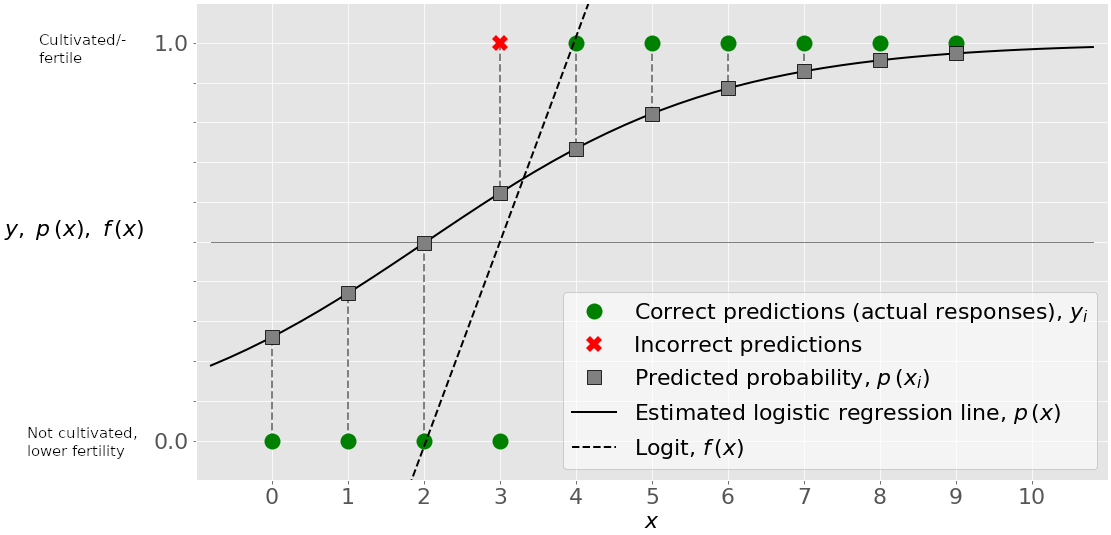

In [15]:
print("Logistic Regression: 1-dimensional representation")
Image(filename='img/logisticregression.png') 

In [16]:
n_components = 5

pca = PCA(n_components= n_components)
principalComponents = pca.fit_transform(X_cult_scaled)

df_PCA_composition = pd.DataFrame(data = principalComponents , columns = ['compositional_component1','compositional_component2','compositional_component3','compositional_component4','compositional_component5'])


print('the new component contains',pca.explained_variance_ratio_ * 100, '% of the information from the', n_components ,'variables', 'for a total of',sum(pca.explained_variance_ratio_ * 100),'%' )
#

the new component contains [29.96301914 20.2434809  15.12417286  9.49691268  6.78998071] % of the information from the 5 variables for a total of 81.61756627269736 %


In [19]:
importance = lr_cultivated.coef_[0]
cult_features = df_composition_cultivated.drop(['Cultivated_n'], axis = 1)
print('all features',cult_features.columns, len(cult_features.columns) )
names_of_variables =cult_features.columns

#create random weights and get the magnitude
weights = np.random.rand(4)
abs_weights = np.abs(importance)

#get the sorting indices
sorted_index = np.argsort(abs_weights)[::-1]

#check if the sorting indices are correct
print(abs_weights[sorted_index])

#get the index of the top-2 features
top_5 = sorted_index[:5]

#get the names of the top 2 most important features
print(names_of_variables[top_5])
ls_top5 = names_of_variables[top_5].tolist()
ls_top5[3] = 'water content'

all features Index(['pH', 'Acidified carbon', 'Flash2000_N_ppm', 'Awc1', 'P', 'K', 'S',
       'Ca', 'Mg', 'Cu', 'Cl', 'Zn', 'Fe', 'Mn', 'Mo', 'depth_sub',
       'depth_top'],
      dtype='object') 17
[1.27122298 0.84180645 0.48227514 0.43404857 0.29944111 0.28871865
 0.22505539 0.22500572 0.20900283 0.17127252 0.10291673 0.08259209
 0.07765662 0.07765662 0.06107512 0.02280531]
Index(['Fe', 'Zn', 'Cl', 'Awc1', 'Ca'], dtype='object')


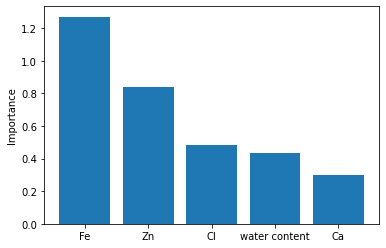

In [20]:
# plot feature importance
plt.bar(ls_top5, abs_weights[sorted_index[:5]])
plt.ylabel('Importance')
plt.show()

#### 2.2.4 Data modeling - major elements correlation

The %N cannot be detected by XRF. It is interesting then to predict it by a correlation with major elements

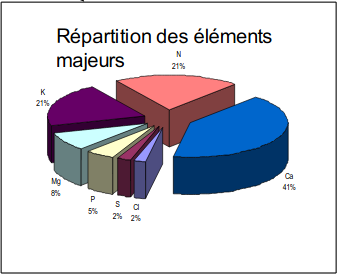

In [21]:
Image(filename='img/majorelements.png')

In [22]:
major_elements = ['Flash2000_N_ppm','P', 'K', 'S', 'Ca', 'Mg', 'Cl','Fe']
df_composition_major = df_composition[major_elements]
print(df_composition_major.shape)
df_composition_major.head()

(467, 8)


,Flash2000_N_ppm,P,K,S,Ca,Mg,Cl,Fe
0,392.82719,50.6,12991.3,45.7,944.1,5575.0,210.2,12501.3
1,859.46908,50.6,15173.5,45.7,9301.0,5519.1,152.6,24094.6
2,186.29957,50.6,6838.9,45.7,884.3,5575.0,229.5,2213.4
3,1026.56581,431.6,15845.8,45.7,46529.1,33771.2,58.2,24135.0
4,377.73812,50.6,12201.6,45.7,1790.1,5575.0,122.5,9135.1


In [23]:
#Variables selection
X_major = df_composition_major.drop(['Flash2000_N_ppm'], axis = 1).values[:, 1:]

X_maj_scaled = StandardScaler().fit_transform(X_major) # scale those features
y_maj = df_composition_major['Flash2000_N_ppm'].values

X0_train, X0_test, y0_train, y0_test = train_test_split(X_maj_scaled, y_maj, test_size = 0.2, random_state = 42)

Multilinear regression

In [24]:
reg = LinearRegression()
reg.fit(X0_train, y0_train)

y0_pred = reg.predict(X0_test)

multilinear_r2 = r2_score(y0_test,y0_pred)


# Calculate mean squared error for the regression
multilinear_mse = mean_squared_error(y0_test, y0_pred)
multilinear_rmse = np.sqrt(multilinear_mse)
print('R2: %5.3f'  % multilinear_r2)

print('RMSE: %5.3f' % multilinear_rmse)

y0_pred_scaled = y0_pred/max(y0_pred)
y0_test_scaled = y0_test/max(y0_test)
scaled_RMSE = np.sqrt(mean_squared_error(y0_test_scaled, y0_pred_scaled))
print('scaled RMSE' ,np.round(scaled_RMSE,2) )

R2: -1.187
RMSE: 1125.092
scaled RMSE 0.43


XGBoost

In [25]:
#kfold = KFold(shuffle=True, random_state=0, n_splits=4)
xgb = XGBRegressor(n_estimators=500, min_child_weight=20, n_jobs=-1, objective='reg:squarederror')

xgb.fit(X0_train, y0_train)

y_pred_xgb = xgb.predict(X0_test)#.reshape(1, 1))

# Calculate scores for the regression
xgb_score = r2_score(y0_test, y_pred_xgb)

# Calculate mean squared error for the regression
xgb_rmse = np.sqrt(mean_squared_error(y0_test, y_pred_xgb))

print('R2: %5.3f'  % xgb_score)

print('RMSE: %5.3f' % xgb_rmse)
y0_xgb_scaled = y_pred_xgb/max(y_pred_xgb)
y0_test_scaled = y0_test/max(y0_test)
scaled_RMSE = np.sqrt(mean_squared_error(y0_test_scaled, y0_xgb_scaled))
print('scaled RMSE' ,np.round(scaled_RMSE,2) )

R2: 0.366
RMSE: 605.714
scaled RMSE 0.16


Random Forest

In [26]:
rf = RandomForestRegressor(max_depth=20, random_state=42)
rf.fit(X0_train, y0_train)

y_pred_rf = rf.predict(X0_test)#.reshape(1, 1))

# Calculate scores for the regression
rf_score = r2_score(y0_test, y_pred_rf)

# Calculate mean squared error for the regression
rf_rmse = np.sqrt(mean_squared_error(y0_test, y_pred_rf))

print('R2: %5.3f'  % rf_score)

print('RMSE: %5.3f' % rf_rmse)
y0_rf_scaled = y_pred_xgb/max(y_pred_rf)
y0_test_scaled = y0_test/max(y0_test)
scaled_RMSE = np.sqrt(mean_squared_error(y0_test_scaled, y0_rf_scaled))
print('scaled RMSE' ,np.round(scaled_RMSE,2) )

R2: 0.539
RMSE: 516.346
scaled RMSE 0.17


In [27]:
rf_importance = rf.feature_importances_
comp_features = df_composition_major.drop(['Flash2000_N_ppm'], axis = 1)
print('all features',comp_features.columns, len(comp_features.columns) )
names_of_variables =comp_features.columns

#create random weights and get the magnitude
weights = np.random.rand(4)
abs_weights = np.abs(rf_importance)

#get the sorting indices
sorted_index = np.argsort(abs_weights)[::-1]

#check if the sorting indices are correct
print(abs_weights[sorted_index])

#get the index of the top-2 features
top_5 = sorted_index[:5]

#get the names of the top 2 most important features
print(names_of_variables[top_5])
ls_top5 = names_of_variables[top_5].tolist()
ls_top5

all features Index(['P', 'K', 'S', 'Ca', 'Mg', 'Cl', 'Fe'], dtype='object') 7
[0.33644053 0.28435927 0.15141579 0.11729529 0.08574149 0.02474762]
Index(['Cl', 'K', 'P', 'Mg', 'S'], dtype='object')


['Cl', 'K', 'P', 'Mg', 'S']

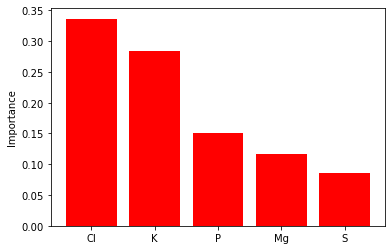

In [28]:
# plot feature importance
plt.bar(ls_top5, abs_weights[sorted_index[:5]], color = 'r')
plt.ylabel('Importance')
plt.show()

Poor correlation between elements concentration

## 3. Elemental analysis - Infrared spectroscopy correlation

### 3.1 Loading mid-infrared spectra and target variables

In [29]:
df_FTIR_raw = pd.read_csv('middle_infrared_spectra_dataset.csv')
todrop = ['SSN'] #irrelevant
df_FTIR = df_FTIR_raw.drop(todrop, axis = 1)
X = df_FTIR.values #spectra are already scaled
X_scaled = StandardScaler().fit_transform(X) 

##### Targets selection

In [30]:
df_composition['%N'] = df_composition['Flash2000_N_ppm']/1000
# single target regression
target_feature = '%N' #['C % Org', '%P', '%K']#, '%Ca', '%Cu', '%Fe', '%Mo','pH'
# multiple targets regression
target_features = ['%N', 'Acidified carbon', 'pH']#, '%Ca', '%Cu', '%Fe', '%Mo','pH']

y2 = df_composition[target_feature].values #PLS1 - single feature regression
Y2 = df_composition[target_features].values #PLS2 - multiple features regression
Y2_scaled = StandardScaler().fit_transform(Y2) 
print('shapes verification',y2.shape, Y2.shape)

shapes verification (467,) (467, 3)


In [31]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_scaled, y2, test_size = 0.2, random_state = 42)

In [32]:
print(np.count_nonzero(y2 < 0))
print(np.count_nonzero(Y2[:,0] < 0))
print(np.count_nonzero(Y2_scaled[:,0] < 0)) # variables have been centered

0
0
316


### 3.2 Multivariate linear regression

In [34]:
lr = LinearRegression()

lr_model = lr.fit(X2_train,y2_train)

y_lr = lr.predict(X2_test)  
r2_lr = r2_score(y2_test, y_lr)
rmse_lr = np.sqrt(mean_squared_error(y2_test, y_lr))
print('linear regression R²',r2_lr )
print('linear regression RMSE',rmse_lr )

linear regression R² -4.398603753886251
linear regression RMSE 1.76763619689215


Text(0.5, 1.0, 'Multivariate linear regression')

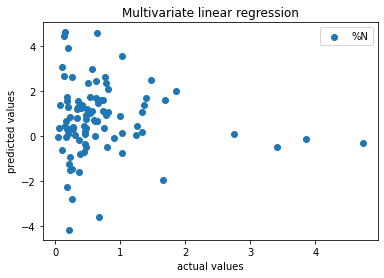

In [35]:
plt.scatter(y2_test, y_lr, label = target_feature)
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Multivariate linear regression')

### 3.4 Ridge regression

In [78]:
parameters = {'alpha':np.logspace(-4, -3.5, 50)}
#Run a Grid search, using R^2 as the metric to optimise alpha
ridge= GridSearchCV(Ridge(), parameters, scoring='r2', cv=10)
# Fit to the data
ridge.fit(X2_train, y2_train)
# Run a ridge regression with the optimised value
print('Best parameter alpha = ', ridge.best_params_['alpha'])

y_ridge = ridge.predict(X2_test)  
#Get the optimised value of alpha

print('ridge regression R² : %5.3f'  % ridge.score(X2_train, y2_train))
rmse_ridge = np.sqrt(mean_squared_error(y2_test, y_ridge))
print('ridge regression RMSE', np.round(rmse_ridge,2) )

Best parameter alpha =  0.00031622776601683794
ridge regression R² : 0.990
ridge regression RMSE 1.54


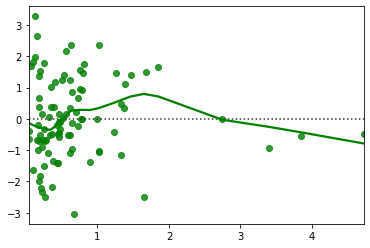

In [79]:
sns.residplot(y2_test, y_ridge, lowess=True, color="g")

Text(0.5, 1.0, 'Ridge regression')

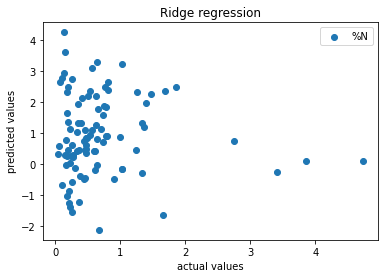

In [80]:
plt.scatter(y2_test, y_ridge, label = target_feature)
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Ridge regression')

### 3.3 Random forest regression

In [38]:

X2, y2 = make_regression(n_features=len(df_FTIR.columns), n_informative=150,random_state=0, shuffle=False)

rf = RandomForestRegressor(max_depth=20, random_state=42)
rf.fit(X2_train, y2_train)
y_pred_rf = rf.predict(X2_test)#.reshape(1, 1))

# Calculate score R2
rf_score_c = r2_score(y2_test, y_pred_rf)

# Calculate root mean squared error
rf_rmse_c = np.sqrt(mean_squared_error(y2_test, y_pred_rf))

print('random forest regression R²: %5.3f'  % rf_score_c)

print('random forest regression RMSE: %5.3f' % np.round(rf_rmse_c,2))


random forest regression R²: -0.180
random forest regression RMSE: 0.830


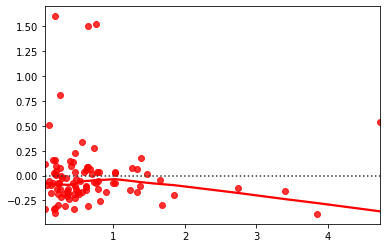

In [76]:
sns.residplot(y2_test, y_pred_rf, lowess=True, color="r")

Text(0.5, 1.0, 'Random forest regression')

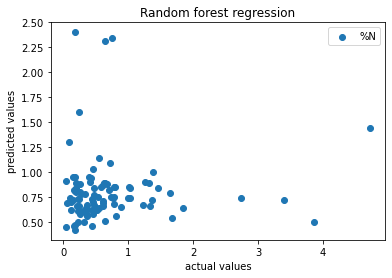

In [39]:
plt.scatter(y2_test, y_pred_rf, label = target_feature)
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Random forest regression')

### 3.2 Multivariate partial least squares (PLS) regression
#### PLS1: univariate target 

NIR spectra should be correlated to COH elements, i.e. organic carbon and we investigate the correlation between these data with multivariate partial least squares regression. The predicting variables are the FTIR wavelenghts. The target is % organic C. 


In [40]:
# what is the optimal number of latent predictive features?
n_comp = 30
mse = []
r2 = []
component = np.arange(1, n_comp,2)
    
for i in component:
    pls = PLSRegression(n_components=i)
    model = pls.fit(X2_train, y2_train)
    
    y_c = model.predict(X2_test)

    mse.append(mean_squared_error(y2_test, y_c))
    r2.append(r2_score(y2_test, y_c))

Text(0.5, 0, 'Number of PLS components')

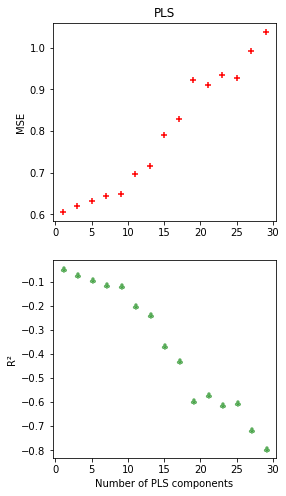

In [41]:
plt.figure(figsize= (4,8))
plt.subplot(211)
plt.scatter(component, mse, label = 'mse', marker = '+', c='r')
plt.title('PLS')
plt.ylabel('MSE')

plt.subplot(212)
plt.scatter(component, r2, label = 'R²', alpha=0.5, marker=r'$\clubsuit$', c='g')
plt.ylabel('R²')
plt.xlabel('Number of PLS components')

Now let's run this function by setting the optimized mumber of components.

In [42]:
pls = PLSRegression(n_components=19)
model_pls = pls.fit(X2_train, y2_train)

y_c = model_pls.predict(X2_test)


# Calculate score
score_c = r2_score(y2_test, y_c)



# Calculate root mean squared error 
rmse_c = np.sqrt(mean_squared_error(y2_test, y_c))

print('PLS R²: %5.3f'  % score_c)

print('PLS RMSE: %5.3f' % rmse_c)

PLS R²: -0.595
PLS RMSE: 0.961


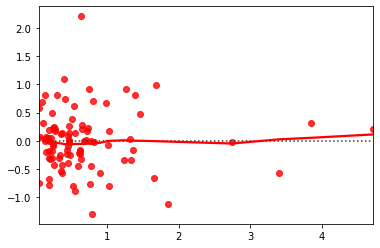

In [75]:
sns.residplot(y2_test, y_c, lowess=True, color="r")

Text(0.5, 1.0, 'PLS regression')

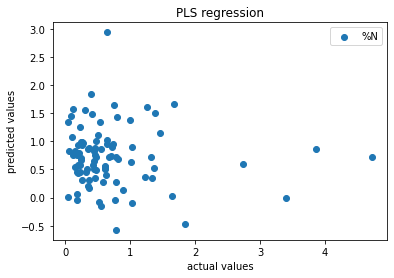

In [43]:
plt.scatter(y2_test, y_c, label = target_feature)
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('PLS regression')

- PLS canonical

In [71]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y2, test_size = 0.2, random_state = 42)

In [72]:
print('n targets: ',len(target_features))

plsca = PLSCanonical(n_components= len(target_features))
model_pls_canonical = plsca.fit(X2_train, Y2_train)
X_c, Y_c = plsca.transform(X2_test, Y2_test)



n targets:  3


In [73]:

# Calculate scores 
plsca_score_c = r2_score(Y2_test, Y_c)

# Calculate mean squared error 
plsca_mse_c = mean_squared_error(Y2_test, Y_c)


print('R² score',target_features[0],': ',r2_score(Y2_test[:,0], Y_c[:,0]))
print('R² score',target_features[1],': ',r2_score(Y2_test[:,1], Y_c[:,1]))
print('R² score',target_features[2],': ',r2_score(Y2_test[:,2], Y_c[:,2]))
print('')
print('R² PLS Canonical average: %5.3f'  % plsca_score_c)
print('RMSE score',target_features[0],': ',np.round(np.sqrt(mean_squared_error(Y2_test[:,0], Y_c[:,0])),2))
print('RMSE PLS Canonical average: %5.3f' % np.round(np.sqrt(plsca_mse_c),2))


R² score %N :  -0.81567066148942
R² score Acidified carbon :  -1.6122815445420904
R² score pH :  -32.26697742947985

R² PLS Canonical average: -11.565
RMSE score %N :  1.03
RMSE PLS Canonical average: 3.710


[]

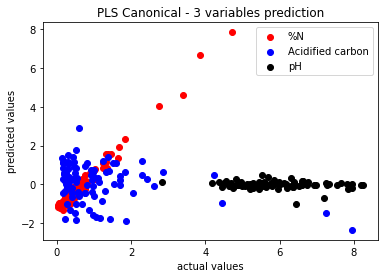

In [74]:
plt.scatter(Y2_test[:,0], Y_c[:,0], label = target_features[0], color = 'r')
plt.scatter(Y2_test[:,1], Y_c[:,1], label = target_features[1], color = 'b')
plt.scatter(Y2_test[:,2], Y_c[:,2], label = target_features[2], color = 'k')
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('PLS Canonical - 3 variables prediction')
plt.plot()

## 4. PLS improvement

Results can be improved as described in https://www.sciencedirect.com/science/article/abs/pii/S0016706119302368

- algorithm can be modified
- FTIR data can be further processed

### 4.1 Prediction using a convolutional neural network (CNN)

In [185]:
#X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y2, test_size = 0.2, random_state = 42)

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y2, test_size=0.2, random_state=42)
X2_train, X2_val, Y2_train, Y2_val = train_test_split(X2_train, Y2_train, test_size=0.1, random_state=1)

In [186]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D,Conv2D, Reshape, MaxPooling1D
from keras.constraints import maxnorm
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.layers.noise import GaussianNoise

#### 4.1.1 CNN used for chemiometrics in the literature
https://github.com/EBjerrum/Deep-Chemometrics

In [227]:
#Hyperparameters for the network
DENSE = 128
DROPOUT = 0.5
C1_K  = 8 #Number of kernels/feature extractors for first layer
C1_S  = 32 #Width of the convolutional mini networks
C2_K  = 16
C2_S  = 32

activation='relu'

input_dim = X2_train.shape[1]

#The model
def make_model1():
    model = Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(GaussianNoise(0.05, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(Reshape((input_dim, 1)))
    model.add(Conv1D(C1_K, (C1_S), activation=activation, padding="same"))
    model.add(Conv1D(C2_K, (C2_S), padding="same", activation=activation))
    model.add(Flatten())
    model.add(Dropout(DROPOUT))
    model.add(Dense(DENSE, activation=activation))
    model.add(Dense(3, activation='linear'))

    model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))#, metrics=['mean_absolute_error'])

    return model

In [228]:
original_model = make_model1()
print(original_model.summary())

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_36 (GaussianN (None, 2542)              0         
_________________________________________________________________
reshape_30 (Reshape)         (None, 2542, 1)           0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 2542, 8)           264       
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 2542, 16)          4112      
_________________________________________________________________
flatten_25 (Flatten)         (None, 40672)             0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 40672)             0         
_________________________________________________________________
dense_90 (Dense)             (None, 128)             

In [229]:
rdlr = ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

h1 = original_model.fit(X2_train, Y2_train, epochs=2000, batch_size=4, validation_data=(X2_val, Y2_val), callbacks=[rdlr])

Epoch 1/2000
84/84 [==============================] - 3s 30ms/step - loss: 2.0665 - val_loss: 1.3157 - lr: 0.0100
Epoch 2/2000
84/84 [==============================] - 2s 29ms/step - loss: 1.2080 - val_loss: 1.2549 - lr: 0.0100
Epoch 3/2000
84/84 [==============================] - 2s 29ms/step - loss: 1.1881 - val_loss: 1.2518 - lr: 0.0100
Epoch 4/2000
84/84 [==============================] - 3s 30ms/step - loss: 1.1481 - val_loss: 1.2374 - lr: 0.0100
Epoch 5/2000
84/84 [==============================] - 2s 29ms/step - loss: 1.2031 - val_loss: 1.2351 - lr: 0.0100
Epoch 6/2000
84/84 [==============================] - 2s 30ms/step - loss: 1.1397 - val_loss: 1.2180 - lr: 0.0100
Epoch 7/2000
84/84 [==============================] - 3s 30ms/step - loss: 1.1577 - val_loss: 1.2726 - lr: 0.0100
Epoch 8/2000
84/84 [==============================] - 2s 29ms/step - loss: 1.2001 - val_loss: 1.2013 - lr: 0.0100
Epoch 9/2000
84/84 [==============================] - 2s 29ms/step - loss: 1.1694 - val_

No handles with labels found to put in legend.


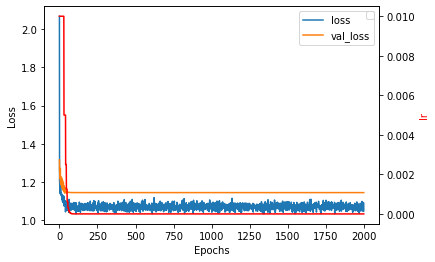

In [230]:
plt.plot(h1.history['loss'], label='loss')
plt.plot(h1.history['val_loss'], label='val_loss')

plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h1.history['lr'], color='r')
ax2.set_ylabel('lr',color='r')

_ = plt.legend()

#### 4.1.2 CNN with additional layers

Modified model

In [231]:
#Hyperparameters for the network
DENSE = 100
DROPOUT = 0.3
C1_K  = 8 #Number of kernels/feature extractors for first layer
C1_S  = 16 #Width of the convolutional mini networks
C2_K  = 8
C2_S  = 16

activation='relu'

input_dim = X2_train.shape[1]

#The model
def make_model():
    model = Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(GaussianNoise(0.02, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(Reshape((input_dim, 1)))
    model.add(Conv1D(C1_K, (C1_S), activation=activation, padding="same"))
    model.add(Conv1D(C2_K, (C2_S), padding="same", activation=activation))
    model.add(Conv1D(8, (8), padding="same", activation=activation))
    model.add(Flatten())
    model.add(Dense(1028, activation='tanh', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='tanh', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))
    model.add(Dense(256, activation='tanh', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))
    model.add(Dense(128, activation='tanh', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))
    model.add(Dense(DENSE, activation=activation))
    model.add(Dense(3, activation='linear'))

    #model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.005))#, metrics=['mean_absolute_error'])
    model.compile(loss='mse', metrics=['accuracy'], optimizer=keras.optimizers.Adadelta(lr=0.005))#, metrics=['mean_absolute_error'])
     
    return model

In [232]:
model = make_model()
print(model.summary())

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_37 (GaussianN (None, 2542)              0         
_________________________________________________________________
reshape_31 (Reshape)         (None, 2542, 1)           0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 2542, 8)           136       
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 2542, 8)           1032      
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 2542, 8)           520       
_________________________________________________________________
flatten_26 (Flatten)         (None, 20336)             0         
_________________________________________________________________
dense_92 (Dense)             (None, 1028)            

We need higher "patience" and number of epochs as the training set lenght is much smaller without data augmentation

In [233]:
rdlr = ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

h = model.fit(X2_train, Y2_train, epochs=2000, batch_size=4, validation_data=(X2_val, Y2_val), callbacks=[rdlr])

Epoch 1/2000
84/84 [==============================] - 14s 166ms/step - loss: 10.4172 - accuracy: 0.7940 - val_loss: 10.0093 - val_accuracy: 0.9737 - lr: 0.0050
Epoch 2/2000
84/84 [==============================] - 14s 165ms/step - loss: 8.8697 - accuracy: 0.8478 - val_loss: 8.7943 - val_accuracy: 0.9737 - lr: 0.0050
Epoch 3/2000
84/84 [==============================] - 14s 165ms/step - loss: 8.4070 - accuracy: 0.8836 - val_loss: 7.8291 - val_accuracy: 0.9737 - lr: 0.0050
Epoch 4/2000
84/84 [==============================] - 14s 166ms/step - loss: 7.3797 - accuracy: 0.9164 - val_loss: 6.4347 - val_accuracy: 0.9737 - lr: 0.0050
Epoch 5/2000
84/84 [==============================] - 14s 168ms/step - loss: 6.8376 - accuracy: 0.9343 - val_loss: 6.3989 - val_accuracy: 0.9737 - lr: 0.0050
Epoch 6/2000
84/84 [==============================] - 14s 168ms/step - loss: 6.5324 - accuracy: 0.9134 - val_loss: 5.8180 - val_accuracy: 0.9737 - lr: 0.0050
Epoch 7/2000
84/84 [==============================

No handles with labels found to put in legend.


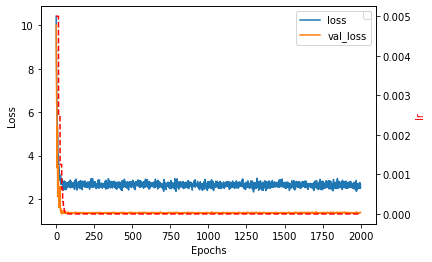

In [234]:
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')

#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h.history['lr'], color='r', linestyle='dashed')
ax2.set_ylabel('lr',color='r')

_ = plt.legend()

In [235]:
Y2_pred = model.predict(X2_test)
print(Y2_pred.shape, Y2_test.shape)

(94, 3) (94, 3)


In [236]:
model_R2 = np.sqrt(r2_score(Y2_test, Y2_pred))

# Calculate mean squared error 
model_RMSE = np.sqrt(mean_squared_error(Y2_test, Y2_pred))


print('R² score',target_features[0],': ',r2_score(Y2_test[:,0], Y2_pred[:,0]))
print('R² score',target_features[1],': ',r2_score(Y2_test[:,1], Y2_pred[:,1]))
print('R² score',target_features[2],': ',r2_score(Y2_test[:,2], Y2_pred[:,2]))
print('')
print('R² CNN:', model_R2)
print('RMSE score',target_features[0],': ',np.round(np.sqrt(mean_squared_error(Y2_test[:,0], Y2_pred[:,0])),2))
print('RMSE CNN average: %5.3f' % np.round(model_RMSE,2))

R² score %N :  -0.19789398077672504
R² score Acidified carbon :  -0.09992447154981132
R² score pH :  -0.5277476393680278

R² CNN: nan
RMSE score %N :  0.83
RMSE CNN average: 1.170


<ipython-input-236-493b552ff1b2>:1: RuntimeWarning: invalid value encountered in sqrt
  model_R2 = np.sqrt(r2_score(Y2_test, Y2_pred))


[]

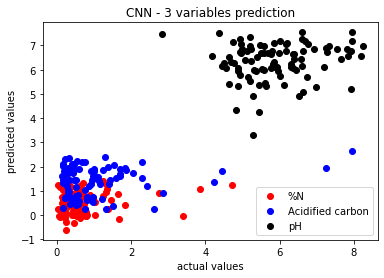

In [237]:

plt.scatter(Y2_test[:,0], Y2_pred[:,0], label = target_features[0], color = 'r')
plt.scatter(Y2_test[:,1], Y2_pred[:,1], label = target_features[1], color = 'b')
plt.scatter(Y2_test[:,2], Y2_pred[:,2], label = target_features[2], color = 'k')
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('CNN - 3 variables prediction')
plt.plot()

In [249]:
Y2_origpred = original_model.predict(X2_test)
print(Y2_origpred.shape, Y2_test.shape)

(94, 3) (94, 3)


In [250]:
origmodel_R2 = np.sqrt(r2_score(Y2_test, Y2_origpred))

# Calculate mean squared error 
origmodel_RMSE = np.sqrt(mean_squared_error(Y2_test, Y2_origpred))


print('R² score',target_features[0],': ',r2_score(Y2_test[:,0], Y2_origpred[:,0]))
print('R² score',target_features[1],': ',r2_score(Y2_test[:,1], Y2_origpred[:,1]))
print('R² score',target_features[2],': ',r2_score(Y2_test[:,2], Y2_origpred[:,2]))
print('')
print('R² CNN:', origmodel_R2)
print('RMSE score',target_features[0],': ',np.round(np.sqrt(mean_squared_error(Y2_test[:,0], Y2_origpred[:,0])),2))
print('RMSE CNN average: %5.3f' % np.round(origmodel_RMSE,2))

R² score %N :  -0.1251324581900306
R² score Acidified carbon :  -0.04479367470603424
R² score pH :  -0.08828018689922934

R² CNN: nan
RMSE score %N :  0.81
RMSE CNN average: 1.080


<ipython-input-250-5203373570a6>:1: RuntimeWarning: invalid value encountered in sqrt
  origmodel_R2 = np.sqrt(r2_score(Y2_test, Y2_origpred))


[]

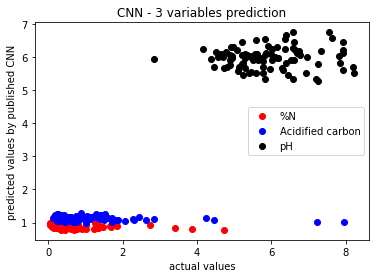

In [251]:

plt.scatter(Y2_test[:,0], Y2_origpred[:,0], label = target_features[0], color = 'r')
plt.scatter(Y2_test[:,1], Y2_origpred[:,1], label = target_features[1], color = 'b')
plt.scatter(Y2_test[:,2], Y2_origpred[:,2], label = target_features[2], color = 'k')
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values by published CNN')
plt.title('CNN - 3 variables prediction')
plt.plot()

### 4.2 FTIR spectra baseline correction by differentiation

2542
(467, 2542)


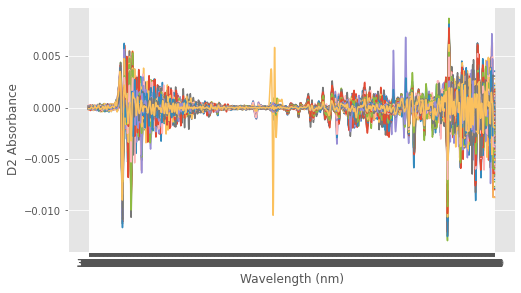

In [238]:


# Get wavelengths
wavelenghts_list = df_FTIR.columns.tolist() 
wavelenghts = np.array(wavelenghts_list)
print(len(wavelenghts))


# Calculate second derivative. That should average baselines
X2 = savgol_filter(X, 17, polyorder = 2,deriv=2)
print(X2.shape)
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wavelenghts, X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()

In [239]:
y2 = df_composition[target_feature].values
X3_train, X3_test, y3_train, y3_test = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

pls = PLSRegression(n_components=10)
model_pls = pls.fit(X3_train, y3_train)

y3_c = model_pls.predict(X3_test)


# Calculate scores for calibration and cross-validation
score3_c = r2_score(y3_test, y3_c)



# Calculate mean squared error for calibration and cross validation
rmse3_c = np.sqrt(mean_squared_error(y3_test, y3_c))

print('PLS R² after spectra differentiation: %5.3f'  % score3_c,'vs.',score_c,'for primitive wave functions')

print('PLS RMSE after spectra differentiation: %5.3f' % rmse3_c,'vs.',rmse_c,'for primitive wave functions')

PLS R² after spectra differentiation: -1.180 vs. -0.5954643262899628 for primitive wave functions
PLS RMSE after spectra differentiation: 1.123 vs. 0.9609387553175943 for primitive wave functions


Text(0.5, 1.0, 'PLS regression for FTIR derivative function')

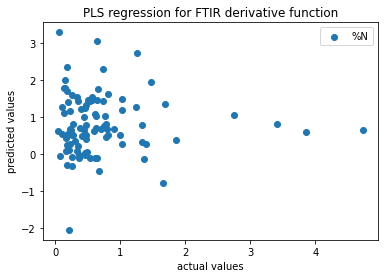

In [240]:
plt.scatter(y3_test, y3_c, label = target_feature)
plt.legend()
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('PLS regression for FTIR derivative function')

### 4.3 FTIR spectra reduction

I select only the regions containing the peaks corresponding to C=O and C=C bonds and filter away the rest of the spectrum containing either a flat or a noisy curve

In [241]:
FTIR_spectra = pd.read_csv('MIR_spectra_transposed.csv')

In [242]:
print(len(FTIR_spectra.labda))

2542


FTIR spectrum example


Text(0.5, 0, 'Wavelengths (cm-1)')

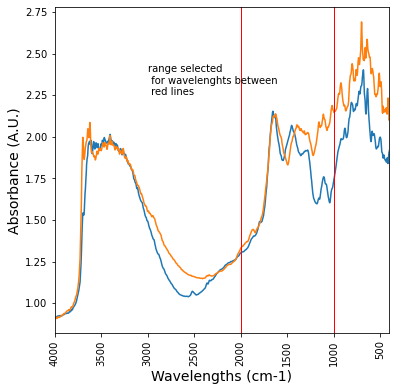

In [243]:
wavelenght_lower_limit = 1000
wavelenght_upper_limit = 2000
print('FTIR spectrum example')
plt.figure(figsize= (6,6))

 
plt.plot(FTIR_spectra['labda'],FTIR_spectra['icr033603'])
plt.plot(FTIR_spectra['labda'],FTIR_spectra['icr048642'])
plt.axvline(x= wavelenght_upper_limit , ymin=0, ymax=1, color='r', linewidth = 1)
plt.axvline(x= wavelenght_lower_limit , ymin=0, ymax=1, color='r', linewidth = 1)
plt.text(3000, 2.25, 'range selected \n for wavelenghts between \n red lines')
plt.xticks(rotation=90)
plt.xlim(4000,400)
plt.ylabel('Absorbance (A.U.)', fontsize=14)
plt.xlabel('Wavelengths (cm-1)', fontsize = 14)

Text(0.5, 0, 'Wavelengths (cm-1)')

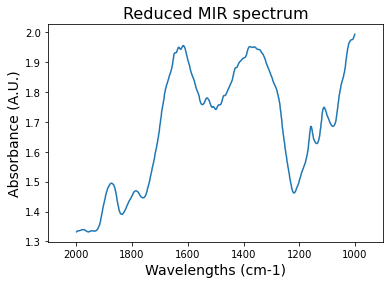

In [244]:
df_MIR_FTIRspectra =  FTIR_spectra[FTIR_spectra['labda'] > wavelenght_lower_limit]  
df_MIR_FTIRspectra = df_MIR_FTIRspectra[df_MIR_FTIRspectra['labda'] < wavelenght_upper_limit] 

plt.plot(df_MIR_FTIRspectra['labda'],df_MIR_FTIRspectra['icr042897']) 
plt.xlim( wavelenght_upper_limit+100,wavelenght_lower_limit-100)
plt.title('Reduced MIR spectrum', fontsize=16)
plt.ylabel('Absorbance (A.U.)', fontsize=14)
plt.xlabel('Wavelengths (cm-1)', fontsize = 14)

In [245]:
df_FTIR_reindexed = df_MIR_FTIRspectra.set_index('labda')
mid_infrared_df = df_FTIR_reindexed.T.reset_index()
mid_infrared_df = mid_infrared_df.rename(columns={'index': 'SSN'})

In [246]:
sampleslist = df_composition['SSN'].tolist()
print('before selection',mid_infrared_df.shape)
mid_infrared_df = mid_infrared_df[mid_infrared_df['SSN'].isin(sampleslist)]
print('after selection',mid_infrared_df.shape)
mid_infrared_df = mid_infrared_df.drop(['SSN'], axis = 1)

before selection (1888, 706)
after selection (467, 706)


In [247]:
X4 = mid_infrared_df.values
y4 = df_composition[target_feature].values

print(X4.shape, y4.shape)

(467, 705) (467,)


In [248]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.2, random_state = 42)

pls = PLSRegression(n_components=10)
model_pls = pls.fit(X4_train, y4_train)

y4_c = model_pls.predict(X4_test)


# Calculate scores for calibration and cross-validation
score4_c = r2_score(y4_test, y4_c)



# Calculate mean squared error for calibration and cross validation
mse4_c = mean_squared_error(y4_test, y4_c)

print('PLS R² after spectra reduction: %5.3f'  % score4_c,'vs.',score_c,'for full spectra')

print('PLS RMSE after spectra reduction: %5.3f' % np.sqrt(mse4_c),'vs.',rmse_c,'for full spectra')

PLS R² after spectra reduction: -0.112 vs. -0.5954643262899628 for full spectra
PLS RMSE after spectra reduction: 0.802 vs. 0.9609387553175943 for full spectra
